# Tutorial using recipes

Recipes are scripted functions that cover probably 90% of cases. They read and save all information to disk using the HDF5 format and have sensible defaults. If you need more flexibility for your calculation, you can run in full control mode instead. 

In a production run, each one of these cells would most likely best be executed as a job. In that case, you would want to separate the computationally intensive runs from the analysis.

You will need to install `pyscf`, `ase`, `matplotlib`, `h5py`, `pandas` and `pyqmc` to use these routines. These all can be installed using `pip`. 

In [1]:
import os
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"
import numpy as np
import pandas as pd
from pyscf import gto, scf
import pyqmc.api as pyq
import h5py
import matplotlib.pyplot as plt
from ase.data.pubchem import pubchem_atoms_search
import pyscf.pbc.tools.pyscf_ase as pyscf_ase
# Here we reset the files 
for fname in ['mf.hdf5','optimized_wf.hdf5','vmc_data.hdf5','dmc.hdf5']:
    if os.path.isfile(fname):
        os.remove(fname) 

/opt/homebrew/Caskroom/miniforge/base/envs/python3.9/lib/python3.9/site-packages/pyscf/lib/misc.py:46: H5pyDeprecationWarning: Using default_file_mode other than 'r' is deprecated. Pass the mode to h5py.File() instead.
  h5py.get_config().default_file_mode = 'a'


This function computes the mean-field solution and saves the results to the file specified. We recommend using the ccecp pseudopotentials for high accuracy and efficiency.

Here we search up the atomic positions of water to reduce errors. 

In [2]:
def mean_field(chkfile):
    atoms =  pubchem_atoms_search(name='water')
    mol = gto.M(
        atom=pyscf_ase.ase_atoms_to_pyscf(atoms),
        basis="ccECP_cc-pVDZ", ecp="ccecp",
    )
    mf = scf.RHF(mol)
    mf.chkfile = chkfile
    mf.kernel()
mean_field("mf.hdf5")

converged SCF energy = -16.9321257267691


Now we wish to construct a Slater-Jastrow wave function and optimize its energy. This is done using the OPTIMIZE function in pyq. It's often helpful to do the first optimization with only a few configurations, to get close to the minimum cheaply.

By default, `OPTIMIZE` uses 10 VMC blocks of 10 steps each, so this is 10x10x100=10,000 VMC samples per iteration. 

To increase precision, it is usually best to increase the number of configurations. 

In [3]:
pyq.OPTIMIZE("mf.hdf5",           #Construct a Slater-Jastrow wave function from the pyscf output
             "optimized_wf.hdf5", #Store optimized parameters in this file.
             nconfig=100,         #Optimize using this many Monte Carlo samples/configurations
             max_iterations=10,   #10 optimization steps
             verbose=False)

The API contains functions such as `read_opt` which assist in reading the output files. Here we print out the energy and uncertainty as the optimization proceeds. You should see that the energy is decreasing (within uncertainty). 

In [4]:
df = pyq.read_opt("optimized_wf.hdf5")
df

,energy,iteration,error,fname
0,-16.991545,0,0.017707,optimized_wf.hdf5
1,-17.080173,1,0.018693,optimized_wf.hdf5
2,-17.126727,2,0.010658,optimized_wf.hdf5
3,-17.116194,3,0.009721,optimized_wf.hdf5
4,-17.109356,4,0.011984,optimized_wf.hdf5
5,-17.123817,5,0.010352,optimized_wf.hdf5
6,-17.150079,6,0.011616,optimized_wf.hdf5
7,-17.148353,7,0.010380,optimized_wf.hdf5
8,-17.158911,8,0.009709,optimized_wf.hdf5
9,-17.170465,9,0.008196,optimized_wf.hdf5


The output is stored as a standard HDF5 file. You can use `h5py` or other utilities to inspect their contents. Here we print out the 2-body Jastrow coefficients. Overall, these should be negative, since electrons repel each other.

Since we did not request orbital optimization, only the Jastrow was optimized, and only the Jastrow parameters are saved in the output file. 


In [5]:
with h5py.File("optimized_wf.hdf5") as f:
    print("keys", list(f.keys()))
    print("wave function parameters", list(f['wf'].keys()))
    print(f['wf/wf2bcoeff'][()])

keys ['configs', 'energy', 'energy_error', 'est_min', 'iteration', 'nconfig', 'pgradient', 'tau', 'wf', 'x', 'yfit']
wave function parameters ['wf2acoeff', 'wf2bcoeff']
[[-0.25       -0.5        -0.25      ]
 [ 0.05606749  0.04630514  0.06288114]
 [-0.10519429 -0.20769824 -0.09778117]
 [-0.13156762 -0.24253197 -0.13787106]]


To evaluate the properties of the wave function, we use the `VMC` function. 

In [6]:
pyq.VMC("mf.hdf5",                            #Construct a Slater-Jastrow wave function from this file
        "vmc_data.hdf5",                      #Store Monte Carlo data in this file
        load_parameters="optimized_wf.hdf5", #Load optimized parameters from this file
        nblocks=30,                           #Run for 30 blocks. By default, there are 10 steps per block and 1000 configurations
        verbose=False)

The uncertainty in the final energy is much lower than in the optimization above, since we sampled many more Monte Carlo configurations. With the above settings, there are 30x1000x10 = 300,000 Monte Carlo samples generated. 

* `energytotal` should match the final step in optimization to within uncertainties
* `energygrad2` should be twice `energyke` within uncertainties
* `energytotal` should be quite a lot lower than the Hartree-Fock energy
* The uncertainties should be lowered (versus the optimization steps above) by a factor $\frac{\sqrt{M_{OPT}}}{\sqrt{M_{VMC}}}$

In [7]:
pyq.read_mc_output("vmc_data.hdf5")

{'fname': 'vmc_data.hdf5',
 'warmup': 1,
 'reblock': None,
 'acceptance': 0.5971488764044944,
 'acceptance_err': 0.0006122970977467954,
 'block': 45.0,
 'block_err': 2.7386127875258306,
 'energyecp': 1.0427315791047875,
 'energyecp_err': 0.006711132061017259,
 'energyee': 17.014264728785488,
 'energyee_err': 0.008604562456597334,
 'energyei': -55.72503351189938,
 'energyei_err': 0.025886049026138145,
 'energygrad2': 26.987968519107632,
 'energygrad2_err': 0.19301283541097783,
 'energyke': 13.597633594791404,
 'energyke_err': 0.01795711497868946,
 'energytotal': -17.170490001013118,
 'energytotal_err': 0.001961047903916406,
 'nconfig': 10000.0,
 'nconfig_err': 0.0}

Finally we run diffusion Monte Carlo. In this example, we have run with many configurations so the convergence of DMC would be very clear. If you want to reduce the computational cost, you can run it with 10x fewer (1000) configurations.


In [8]:
pyq.DMC("mf.hdf5",
        "dmc.hdf5",                            #Initialize the Slater-Jastrow wave function using pyscf
        load_parameters=f"optimized_wf.hdf5",  #Load the optimized parameters
        verbose=False, 
        tstep=.1,                              #timestep of 0.1 Hartrees^-1
        nsteps=int(50/.1),                     #propagate for 50 Hartrees^-1
        branchtime=1,                          #Efficiency parameter; these are 'mini-blocks'
        nconfig=10000)                         #Use 1,000 configurations

We can read the energy directly from the HDF5 file. 

You should see that the first few steps are higher in energy than the average. These are the warmup steps.

Text(0, 0.5, 'Energy (Hartree)')

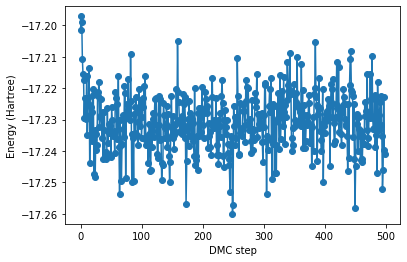

In [12]:
with h5py.File("dmc.hdf5") as f:
    en = f['energytotal'][...]
plt.plot(en, marker='o')
plt.xlabel("DMC step")
plt.ylabel("Energy (Hartree)")

Since the DMC samples are correlated due to the timestepping, it is important to do two things: 
1) Remove the warmup steps.  
2) Reblocking analysis to estimate the statistical uncertainties correctly. 

The `read_mc_output` function has two parameters that help with this:
* `warmup`: remove the first `warmup` steps from the data, before reblocking
* `reblock`: bin the data into `reblock` blocks.


[250, 100, 62, 45, 35, 27, 23, 20, 18, 16]
[ 2  5  8 11 14 18 21 24 27 31]


Text(0, 0.5, 'Estimated uncertainty (Ha)')

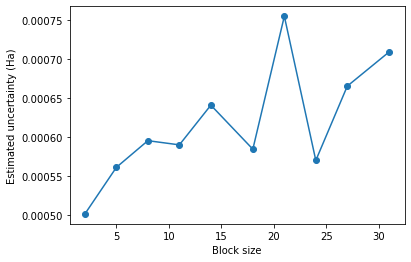

In [13]:
block_sizes = np.linspace(2,len(en)//16, 10, dtype=int)
reblocks = [len(en)//s for s in block_sizes]
print(reblocks)
print(block_sizes)
df = pd.DataFrame([pyq.read_mc_output("dmc.hdf5", warmup=100, reblock=reblock) for reblock in reblocks])
df['block_size'] = block_sizes
plt.plot("block_size",'energytotal_err',data=df, marker='o')
plt.xlabel("Block size")
plt.ylabel("Estimated uncertainty (Ha)")